In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.interpolate as interp
import scipy as sp
import re
import tensorflow as tf
import tensorflow.keras as keras
from helper_functions import *


In [3]:
#create dataset
data = []
truth = []

#Each loop picks a skewer, and labels the galaxies near to it. 
#There is double counting probably if skewers pass near each other, but this is fine
#A galaxy can impact more than one LOS
LOS_num = 8
#parameters for binning. Adjust this to get finer and wider bins
distance_along_LOS_bins = 100
mass_bins = 10
radial_bins = 10

root = "../../WORK/REI/a=0.1452"

isTest = 0

gals = np.loadtxt(root+"/hprops.res", usecols=[1,5,6,7],unpack=1) # load data

for i in np.arange(1,LOS_num+1):
    #pulling data from galaxies
    flux_path = root + '/los/los.00' + '{0:03}'.format(i) +'.raw'

    temp = get_galaxies(gals, flux_path, i)
    
    #setting up the bins in which we will categorize our galaxies
    temp = np.swapaxes(temp, 0, 1)[:, 0:3]
       
    #mass
    bin1 = np.logspace(np.log10(min(temp[:,0])), np.log10(max(temp[:,0])), mass_bins+1)
    #along LOS
    bin2 = np.linspace(5,95, distance_along_LOS_bins+1)
    #radial distance
    bin3 = np.linspace(min(temp[:,2]), max(temp[:,2]), radial_bins+1)
    H, edges = np.histogramdd(temp, bins=(bin1, bin2, bin3))
   
    #see how far along this part is
    print(i,np.amin(H),np.amax(H))
    
    if(isTest):
        print(H[0,0,:])
        stop
        flux_temp = new_flux.reshape(int(new_flux.shape[0]/160), 160).mean(axis=1)
    else:
        #pulling truth (what we are trying to predict) from the flux
        flux_path = root + '/los/los.00' + '{0:03}'.format(i) +'.fHI'

        #converting to distance from velocity.
        velocity, flux = unPackRawFlux(flux_path)
        flux_distance = hubble_flow_convert(velocity, a=0.1452, omega_m=0.3036, omega_lam=0.6964)
    
        #they are slightly different lengths so we chop off the ends. Because of peculiar velocity we will lose some info
        new_flux_distance = np.linspace(5,95, 16000)
        new_flux = resample(flux_distance, flux, new_flux_distance)
    
        flux_temp = new_flux.reshape(int(new_flux.shape[0]/160), 160).mean(axis=1)
    
    if len(data)==0:
        data = np.array([H])
        truth = np.array([flux_temp])
    else:
        data = np.append(data, [H], axis=0)
        truth = np.append(truth, [flux_temp], axis=0)

data = data.reshape(LOS_num, 10, 100, 10, 1)
#correction for the future (probably could write this better later to be honest)
data = np.swapaxes(data, 2, 3)

#Now we have a data array, and truth array to test it against

1 0.0 2.0
2 0.0 2.0
3 0.0 2.0
4 0.0 2.0
5 0.0 0.0
6 0.0 2.0
7 0.0 2.0
8 0.0 2.0


In [4]:
#check shapes
print(truth.shape)
print(data.shape)

(8, 100)
(8, 10, 10, 100, 1)


In [5]:
tf.compat.v1.reset_default_graph()

def build_and_compile_model():
    model = keras.Sequential([
        keras.layers.InputLayer(input_shape=(10, 10, distance_along_LOS_bins, 1)),
        keras.layers.Conv3D(filters=1, kernel_size=(mass_bins, 1, 1)),
        keras.layers.Conv3D(filters=1, kernel_size=(1, radial_bins, 1)),
        keras.layers.Flatten(),
        keras.layers.Dense(100),

    ])
    
    model.compile(loss='mean_squared_error',
                optimizer=keras.optimizers.Adam(0.0005))
    
    return model

In [6]:
#build NN and check that it worked, and all dimensions are right
galaxies_spikes = build_and_compile_model()
galaxies_spikes.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 1, 10, 100, 1)     11        
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 1, 1, 100, 1)      11        
_________________________________________________________________
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
Total params: 10,122
Trainable params: 10,122
Non-trainable params: 0
_________________________________________________________________


In [10]:
#train
history = galaxies_spikes.fit(data, truth, epochs=1000)

Train on 8 samples
Epoch 1/1000
8/8 [==============================] - 0s 4ms/sample - loss: 0.0016
Epoch 2/1000
8/8 [==============================] - 0s 494us/sample - loss: 0.0016
Epoch 3/1000
8/8 [==============================] - 0s 499us/sample - loss: 0.0016
Epoch 4/1000
8/8 [==============================] - 0s 623us/sample - loss: 0.0016
Epoch 5/1000
8/8 [==============================] - 0s 620us/sample - loss: 0.0016
Epoch 6/1000
8/8 [==============================] - 0s 502us/sample - loss: 0.0016
Epoch 7/1000
8/8 [==============================] - 0s 623us/sample - loss: 0.0016
Epoch 8/1000
8/8 [==============================] - 0s 620us/sample - loss: 0.0016
Epoch 9/1000
8/8 [==============================] - 0s 493us/sample - loss: 0.0015
Epoch 10/1000
8/8 [==============================] - 0s 499us/sample - loss: 0.0015
Epoch 11/1000
8/8 [==============================] - 0s 622us/sample - loss: 0.0015
Epoch 12/1000
8/8 [==============================] - 0s 623us/sample

Epoch 99/1000
8/8 [==============================] - 0s 495us/sample - loss: 9.3251e-04
Epoch 100/1000
8/8 [==============================] - 0s 623us/sample - loss: 9.2491e-04
Epoch 101/1000
8/8 [==============================] - 0s 493us/sample - loss: 9.1733e-04
Epoch 102/1000
8/8 [==============================] - 0s 627us/sample - loss: 9.0977e-04
Epoch 103/1000
8/8 [==============================] - 0s 620us/sample - loss: 9.0222e-04
Epoch 104/1000
8/8 [==============================] - 0s 623us/sample - loss: 8.9468e-04
Epoch 105/1000
8/8 [==============================] - 0s 499us/sample - loss: 8.8717e-04
Epoch 106/1000
8/8 [==============================] - 0s 499us/sample - loss: 8.7968e-04
Epoch 107/1000
8/8 [==============================] - 0s 499us/sample - loss: 8.7220e-04
Epoch 108/1000
8/8 [==============================] - 0s 502us/sample - loss: 8.6475e-04
Epoch 109/1000
8/8 [==============================] - 0s 496us/sample - loss: 8.5732e-04
Epoch 110/1000
8/8 [==

Epoch 192/1000
8/8 [==============================] - 0s 499us/sample - loss: 3.8188e-04
Epoch 193/1000
8/8 [==============================] - 0s 623us/sample - loss: 3.7809e-04
Epoch 194/1000
8/8 [==============================] - 0s 494us/sample - loss: 3.7435e-04
Epoch 195/1000
8/8 [==============================] - 0s 623us/sample - loss: 3.7064e-04
Epoch 196/1000
8/8 [==============================] - 0s 499us/sample - loss: 3.6699e-04
Epoch 197/1000
8/8 [==============================] - 0s 498us/sample - loss: 3.6337e-04
Epoch 198/1000
8/8 [==============================] - 0s 499us/sample - loss: 3.5979e-04
Epoch 199/1000
8/8 [==============================] - 0s 623us/sample - loss: 3.5626e-04
Epoch 200/1000
8/8 [==============================] - 0s 627us/sample - loss: 3.5277e-04
Epoch 201/1000
8/8 [==============================] - 0s 495us/sample - loss: 3.4931e-04
Epoch 202/1000
8/8 [==============================] - 0s 499us/sample - loss: 3.4590e-04
Epoch 203/1000
8/8 [=

Epoch 285/1000
8/8 [==============================] - 0s 627us/sample - loss: 1.6884e-04
Epoch 286/1000
8/8 [==============================] - 0s 621us/sample - loss: 1.6760e-04
Epoch 287/1000
8/8 [==============================] - 0s 625us/sample - loss: 1.6638e-04
Epoch 288/1000
8/8 [==============================] - 0s 495us/sample - loss: 1.6517e-04
Epoch 289/1000
8/8 [==============================] - 0s 497us/sample - loss: 1.6398e-04
Epoch 290/1000
8/8 [==============================] - 0s 623us/sample - loss: 1.6279e-04
Epoch 291/1000
8/8 [==============================] - 0s 499us/sample - loss: 1.6162e-04
Epoch 292/1000
8/8 [==============================] - 0s 623us/sample - loss: 1.6047e-04
Epoch 293/1000
8/8 [==============================] - 0s 624us/sample - loss: 1.5932e-04
Epoch 294/1000
8/8 [==============================] - 0s 495us/sample - loss: 1.5819e-04
Epoch 295/1000
8/8 [==============================] - 0s 499us/sample - loss: 1.5707e-04
Epoch 296/1000
8/8 [=

Epoch 378/1000
8/8 [==============================] - 0s 495us/sample - loss: 9.3329e-05
Epoch 379/1000
8/8 [==============================] - 0s 625us/sample - loss: 9.2798e-05
Epoch 380/1000
8/8 [==============================] - 0s 623us/sample - loss: 9.2271e-05
Epoch 381/1000
8/8 [==============================] - 0s 499us/sample - loss: 9.1748e-05
Epoch 382/1000
8/8 [==============================] - 0s 623us/sample - loss: 9.1229e-05
Epoch 383/1000
8/8 [==============================] - 0s 499us/sample - loss: 9.0713e-05
Epoch 384/1000
8/8 [==============================] - 0s 499us/sample - loss: 9.0201e-05
Epoch 385/1000
8/8 [==============================] - 0s 623us/sample - loss: 8.9693e-05
Epoch 386/1000
8/8 [==============================] - 0s 499us/sample - loss: 8.9187e-05
Epoch 387/1000
8/8 [==============================] - 0s 620us/sample - loss: 8.8686e-05
Epoch 388/1000
8/8 [==============================] - 0s 495us/sample - loss: 8.8187e-05
Epoch 389/1000
8/8 [=

Epoch 471/1000
8/8 [==============================] - 0s 499us/sample - loss: 5.5762e-05
Epoch 472/1000
8/8 [==============================] - 0s 623us/sample - loss: 5.5454e-05
Epoch 473/1000
8/8 [==============================] - 0s 623us/sample - loss: 5.5147e-05
Epoch 474/1000
8/8 [==============================] - 0s 499us/sample - loss: 5.4842e-05
Epoch 475/1000
8/8 [==============================] - 0s 499us/sample - loss: 5.4538e-05
Epoch 476/1000
8/8 [==============================] - 0s 624us/sample - loss: 5.4236e-05
Epoch 477/1000
8/8 [==============================] - 0s 620us/sample - loss: 5.3935e-05
Epoch 478/1000
8/8 [==============================] - 0s 627us/sample - loss: 5.3636e-05
Epoch 479/1000
8/8 [==============================] - 0s 495us/sample - loss: 5.3338e-05
Epoch 480/1000
8/8 [==============================] - 0s 499us/sample - loss: 5.3042e-05
Epoch 481/1000
8/8 [==============================] - 0s 495us/sample - loss: 5.2747e-05
Epoch 482/1000
8/8 [=

Epoch 564/1000
8/8 [==============================] - 0s 626us/sample - loss: 3.2649e-05
Epoch 565/1000
8/8 [==============================] - 0s 620us/sample - loss: 3.2452e-05
Epoch 566/1000
8/8 [==============================] - 0s 627us/sample - loss: 3.2257e-05
Epoch 567/1000
8/8 [==============================] - 0s 624us/sample - loss: 3.2063e-05
Epoch 568/1000
8/8 [==============================] - 0s 623us/sample - loss: 3.1869e-05
Epoch 569/1000
8/8 [==============================] - 0s 374us/sample - loss: 3.1677e-05
Epoch 570/1000
8/8 [==============================] - 0s 495us/sample - loss: 3.1485e-05
Epoch 571/1000
8/8 [==============================] - 0s 626us/sample - loss: 3.1294e-05
Epoch 572/1000
8/8 [==============================] - 0s 495us/sample - loss: 3.1104e-05
Epoch 573/1000
8/8 [==============================] - 0s 496us/sample - loss: 3.0916e-05
Epoch 574/1000
8/8 [==============================] - 0s 623us/sample - loss: 3.0728e-05
Epoch 575/1000
8/8 [=

Epoch 657/1000
8/8 [==============================] - 0s 499us/sample - loss: 1.8033e-05
Epoch 658/1000
8/8 [==============================] - 0s 623us/sample - loss: 1.7911e-05
Epoch 659/1000
8/8 [==============================] - 0s 499us/sample - loss: 1.7790e-05
Epoch 660/1000
8/8 [==============================] - 0s 502us/sample - loss: 1.7670e-05
Epoch 661/1000
8/8 [==============================] - 0s 495us/sample - loss: 1.7550e-05
Epoch 662/1000
8/8 [==============================] - 0s 627us/sample - loss: 1.7431e-05
Epoch 663/1000
8/8 [==============================] - 0s 495us/sample - loss: 1.7313e-05
Epoch 664/1000
8/8 [==============================] - 0s 499us/sample - loss: 1.7195e-05
Epoch 665/1000
8/8 [==============================] - 0s 623us/sample - loss: 1.7078e-05
Epoch 666/1000
8/8 [==============================] - 0s 499us/sample - loss: 1.6962e-05
Epoch 667/1000
8/8 [==============================] - 0s 502us/sample - loss: 1.6846e-05
Epoch 668/1000
8/8 [=

Epoch 750/1000
8/8 [==============================] - 0s 501us/sample - loss: 9.2431e-06
Epoch 751/1000
8/8 [==============================] - 0s 623us/sample - loss: 9.1729e-06
Epoch 752/1000
8/8 [==============================] - 0s 624us/sample - loss: 9.1032e-06
Epoch 753/1000
8/8 [==============================] - 0s 499us/sample - loss: 9.0338e-06
Epoch 754/1000
8/8 [==============================] - 0s 499us/sample - loss: 8.9649e-06
Epoch 755/1000
8/8 [==============================] - 0s 499us/sample - loss: 8.8965e-06
Epoch 756/1000
8/8 [==============================] - 0s 623us/sample - loss: 8.8285e-06
Epoch 757/1000
8/8 [==============================] - 0s 500us/sample - loss: 8.7609e-06
Epoch 758/1000
8/8 [==============================] - 0s 500us/sample - loss: 8.6938e-06
Epoch 759/1000
8/8 [==============================] - 0s 622us/sample - loss: 8.6271e-06
Epoch 760/1000
8/8 [==============================] - 0s 499us/sample - loss: 8.5608e-06
Epoch 761/1000
8/8 [=

Epoch 843/1000
8/8 [==============================] - 0s 626us/sample - loss: 4.3649e-06
Epoch 844/1000
8/8 [==============================] - 0s 620us/sample - loss: 4.3279e-06
Epoch 845/1000
8/8 [==============================] - 0s 495us/sample - loss: 4.2911e-06
Epoch 846/1000
8/8 [==============================] - 0s 623us/sample - loss: 4.2547e-06
Epoch 847/1000
8/8 [==============================] - 0s 623us/sample - loss: 4.2184e-06
Epoch 848/1000
8/8 [==============================] - 0s 500us/sample - loss: 4.1825e-06
Epoch 849/1000
8/8 [==============================] - 0s 627us/sample - loss: 4.1468e-06
Epoch 850/1000
8/8 [==============================] - 0s 623us/sample - loss: 4.1114e-06
Epoch 851/1000
8/8 [==============================] - 0s 495us/sample - loss: 4.0763e-06
Epoch 852/1000
8/8 [==============================] - 0s 626us/sample - loss: 4.0414e-06
Epoch 853/1000
8/8 [==============================] - 0s 620us/sample - loss: 4.0068e-06
Epoch 854/1000
8/8 [=

Epoch 936/1000
8/8 [==============================] - 0s 623us/sample - loss: 1.8991e-06
Epoch 937/1000
8/8 [==============================] - 0s 619us/sample - loss: 1.8814e-06
Epoch 938/1000
8/8 [==============================] - 0s 499us/sample - loss: 1.8638e-06
Epoch 939/1000
8/8 [==============================] - 0s 623us/sample - loss: 1.8464e-06
Epoch 940/1000
8/8 [==============================] - 0s 623us/sample - loss: 1.8291e-06
Epoch 941/1000
8/8 [==============================] - 0s 499us/sample - loss: 1.8119e-06
Epoch 942/1000
8/8 [==============================] - 0s 499us/sample - loss: 1.7950e-06
Epoch 943/1000
8/8 [==============================] - 0s 623us/sample - loss: 1.7781e-06
Epoch 944/1000
8/8 [==============================] - 0s 627us/sample - loss: 1.7614e-06
Epoch 945/1000
8/8 [==============================] - 0s 495us/sample - loss: 1.7448e-06
Epoch 946/1000
8/8 [==============================] - 0s 495us/sample - loss: 1.7284e-06
Epoch 947/1000
8/8 [=

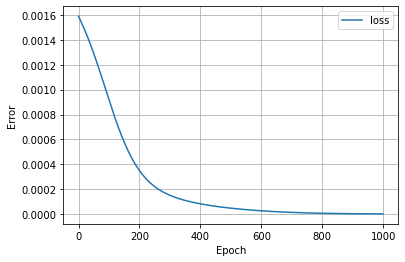

In [11]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
plot_loss(history)

(8, 100)


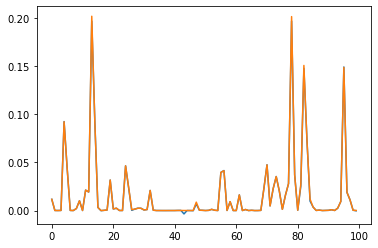

In [12]:
#see if the predictions are actually working. Note, we didn't set aside test data yet.
#I haven't gotten anything to work, so I'm skipping that for now
pred = galaxies_spikes.predict(data)
print(pred.shape)
plt.plot(pred[0,:]*1)
plt.plot(truth[0,:])
plt.show()